# Laboratorio 2 - Complejidad y búsqueda de hiperparámetros
### Sergio David Ferreira - Juan David Gutierrez


## Indice

- [Carga de datos y partición de datos](#toc-carga-de-datos-y-particion-de-datos)
- [Construcción del pipeline](#toc-construccion-del-pipeline)
  - [Codificación de variables categóricas](#toc-codificacion-de-variables-categoricas)
  - [Eliminación de columnas redundantes o innecesarias](#toc-eliminacion-de-columnas-redundantes-o-innecesarias)
  - [Manejo de outliers por rangos válidos de las variables](#toc-manejo-de-outliers-por-rangos-validos-de-las-variables)
  - [Imputación de valores faltantes](#toc-imputacion-de-valores-faltantes)
  - [Eliminación de variables con alta multicolinealidad](#toc-eliminacion-de-variables-con-alta-multicolinealidad)
  - [Escalado MinMax](#toc-escalado-minmax)
  - [Construcción del pipeline final](#toc-construccion-del-pipeline-final)
- [Comparación y selección de modelos](#toc-comparacion-y-seleccion-de-modelos)
  - [Configuración de K-Folds](#toc-configuracion-k-folds)
  - [Evaluación de resultados CV](#toc-evaluacion-de-resultados-cv)
  - [Curvas de validación](#toc-curvas-de-validacion)
  - [Evaluación del mejor modelo](#toc-evaluacion-del-mejor-modelo)
- [Regresión lineal regularizada](#toc-regresion-lineal-regularizada)
  - [Ridge (Regularización L2)](#toc-ridge-regularizacion-l2)
    - [Análisis de coeficientes Ridge](#toc-analisis-de-coeficientes-ridge)
  - [Lasso (Regularización L1)](#toc-lasso-regularizacion-l1)
    - [Análisis de coeficientes Lasso](#toc-analisis-de-coeficientes-lasso)
  - [Comparación: Sin regularización vs Ridge vs Lasso](#toc-comparacion-sin-regularizacion-vs-ridge-vs-lasso)
- [Regresión polinomial regularizada](#toc-regresion-polinomial-regularizada)
  - [Pipeline de regresión polinomial Ridge](#toc-pipeline-de-regresion-polinomial-ridge)
  - [Análisis del efecto de la regularización](#toc-analisis-del-efecto-de-la-regularizacion)
  - [Pipeline de regresión polinomial Lasso](#toc-pipeline-de-regresion-polinomial-lasso)
  - [Análisis del efecto de la regularización](#toc-analisis-del-efecto-de-la-regularizacion-1)
  - [Comparación: polinomial sin regularización vs polinomial Ridge vs polinomial Lasso](#toc-comparacion-polinomial-sin-regularizacion-vs-polinomial-ridge-vs-polinomial-lasso)
- [Comparación y selección del mejor modelo](#toc-comparacion-y-seleccion-del-mejor-modelo)
  - [Selección del mejor modelo y justificación](#toc-seleccion-del-mejor-modelo-y-justificacion)
- [Entrenamiento del mejor modelo](#toc-entrenamiento-del-mejor-modelo)
- [Construcción de intervalos de confianza](#toc-construccion-de-intervalos-de-confianza)
- [Análisis de resultados](#toc-analisis-de-resultados)
- [Uso de IA Generativa](#toc-uso-de-ia-generativa)


## Librerías utilizadas


In [1]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, validation_curve, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<a id="toc-carga-de-datos-y-particion-de-datos"></a>
## Carga de datos y partición de datos
Para la carga de datos se carga el archivo del laboratorio anterior, se eliminan pacientes duplicados y outliers y valores faltantes sobre la columna target, *CVD Risk Score*


In [2]:
data = pd.read_csv('data/Datos Lab 1.csv')

# Normalizamos fechas
data['Date of Service'] = pd.to_datetime(data['Date of Service'], format='mixed')

# Eliminamos pacientes con registros duplicados manteniendo el más reciente
data = data.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])
data = data.drop_duplicates(subset='Patient ID', keep='first')

# Eliminamos registros con valores faltantes en el target
data = data.dropna(subset=['CVD Risk Score'])

# Eliminamos registros de outliers en la variable target
q1 = data['CVD Risk Score'].quantile(0.25)
q3 = data['CVD Risk Score'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

data = data[(data['CVD Risk Score'] > limite_inferior) & (data['CVD Risk Score'] < limite_superior)]

#Mostramos un sample de los datos
data.sample(3)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
436,ObNv1691,2024-07-12,F,43.0,119.900,1.850,52.136,NaN,126/62,220.0,...,Moderate,Y,185.000,0.414,126.0,62.0,Elevated,146.0,17.700,INTERMEDIARY
53,rvPR0222,2022-10-31,F,72.0,113.375,1.842,28.871,81.930,177/67,255.0,...,Low,N,NaN,0.445,177.0,67.0,Hypertension Stage 2,149.0,19.724,HIGH
1,LHCK2961,2024-03-20,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY


Ahora, separamos los datos en entrenamiento y prueba


In [3]:
target = 'CVD Risk Score'
x = data.drop(columns=[target])
y = data[target]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1038, 23) (1038,)
(260, 23) (260,)


<a id="toc-construccion-del-pipeline"></a>
## Construcción del pipeline

Para la construcción del pipeline se sigue el procedimiento del laboratorio anterior, por lo tanto únicamente se enuncian los pasos sin añadir justificaciones del proceso.


<a id="toc-codificacion-de-variables-categoricas"></a>
### Codificación de variables categóricas


In [5]:
numeric_features = [
    "Age", "Weight (kg)", "Height (m)", "Height (cm)", "BMI", "Abdominal Circumference (cm)", 
    "Total Cholesterol (mg/dL)", "HDL (mg/dL)", "Fasting Blood Sugar (mg/dL)", 
    "Waist-to-Height Ratio", "Systolic BP", "Diastolic BP", "Estimated LDL (mg/dL)"
]

ordinal_features = [
    "Physical Activity Level", "Blood Pressure Category"
]

binary_features = [
    "Sex", "Smoking Status", "Diabetes Status", "Family History of CVD"
]

binary_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy=lambda x: random.randint(0, 1)))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories = [
        ['Low', 'Moderate', 'High'],  # Physical Activity Level
        ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']  # Blood Pressure Category
    ]))
])


<a id="toc-eliminacion-de-columnas-redundantes-o-innecesarias"></a>
### Eliminación de columnas redundantes o innecesarias


In [6]:
col_drop = ['Blood Pressure (mmHg)', 'Patient ID', 'Date of Service', 'CVD Risk Level']
def drop_columns(df):
    return df.drop(columns=col_drop, errors='ignore')

dropper = FunctionTransformer(drop_columns)

<a id="toc-manejo-de-outliers-por-rangos-validos-de-las-variables"></a>
### Manejo de outliers por rangos válidos de las variables


In [7]:
rangos = {
    'Diastolic BP': (40, 125),
    'Systolic BP': (80, 190),
    'Fasting Blood Sugar (mg/dL)': (60, 200),
    'Total Cholesterol (mg/dL)': (80, 320),
    'HDL (mg/dL)': (20, 100),
    'Estimated LDL (mg/dL)': (0, 250),
    'BMI': (15, 50),
    'Weight (kg)': (30, 140),
    'Height (m)': (1.45, 2),
    'Height (cm)': (145, 200),
    'Abdominal Circumference (cm)': (60, 130),
    'Waist-to-Height Ratio': (0.35, 0.8),
    'Age': (18, 100)
}
def limpiar_rangos(df):
    for col, (min_val, max_val) in rangos.items():
        if col in df.columns:
            df.loc[
                (df[col] <= min_val) | (df[col] >= max_val),
                col
            ] = np.nan
    return df
rangos_validos = FunctionTransformer(limpiar_rangos)
numeric_transformer = Pipeline(steps=[
    ('rangos', rangos_validos)
])

<a id="toc-imputacion-de-valores-faltantes"></a>
### Imputación de valores faltantes
Variables sin multicolinealidad


In [8]:
clean_numeric_data = numeric_transformer.fit_transform(x_train)
clean_numeric_data = pd.DataFrame(clean_numeric_data, columns=numeric_features)

median_columns = ['Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'HDL (mg/dL)']
mean_columns = ['Weight (kg)', 'BMI']
median_transformer = SimpleImputer(strategy='median')
mean_transformer = SimpleImputer(strategy='mean')
simple_imputer_transformer = ColumnTransformer(transformers=[
    ('median', median_transformer, median_columns),
    ('mean', mean_transformer, mean_columns)
])

Variables con alta colinealidad


In [9]:
class MiImputador(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.k = {}
        # Waist to height ratio
        self.k['Waist-to-Height Ratio'] = \
            (X['Waist-to-Height Ratio'] / X['Abdominal Circumference (cm)']).dropna().median()

        # Abdominal circumference
        self.k['Abdominal Circumference (cm)'] = \
            (X['Abdominal Circumference (cm)'] / X['Waist-to-Height Ratio']).dropna().median()

        # Total cholesterol
        self.k['Total Cholesterol (mg/dL)'] = \
            (X['Total Cholesterol (mg/dL)'] / X['Estimated LDL (mg/dL)']).dropna().median()

        # Estimated LDL
        self.k['Estimated LDL (mg/dL)'] = \
            (X['Estimated LDL (mg/dL)'] / X['Total Cholesterol (mg/dL)']).dropna().median()
        
        return self

    def transform(self, X):
        temp_abdominal = \
            X['Abdominal Circumference (cm)'].fillna(X['Abdominal Circumference (cm)'].mean())
        X['Waist-to-Height Ratio'] = \
            X['Waist-to-Height Ratio'].fillna(self.k['Waist-to-Height Ratio'] * temp_abdominal)
        X['Abdominal Circumference (cm)'] = \
            X['Abdominal Circumference (cm)'].fillna(self.k['Abdominal Circumference (cm)'] * X['Waist-to-Height Ratio'])
        
        temp_ldl = X['Estimated LDL (mg/dL)'].fillna(X['Estimated LDL (mg/dL)'].mean())
        X['Total Cholesterol (mg/dL)'] = \
            X['Total Cholesterol (mg/dL)'].fillna(self.k['Total Cholesterol (mg/dL)'] * temp_ldl)
        X['Estimated LDL (mg/dL)'] = X['Estimated LDL (mg/dL)'].fillna(self.k['Estimated LDL (mg/dL)'] * X['Total Cholesterol (mg/dL)'])

        temp_height = X['Height (m)'].fillna(X['Height (m)'].mean())
        X['Height (cm)'] = X['Height (cm)'].fillna(temp_height * 100)
        X['Height (m)'] = X['Height (m)'].fillna(X['Height (cm)'] / 100)
        
        return X

corr_imputer = MiImputador()
corr_features = ['Waist-to-Height Ratio', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'Estimated LDL (mg/dL)', 'Height (cm)', 'Height (m)']
imputer_transformer = ColumnTransformer(transformers=[
    ('simple', simple_imputer_transformer, median_columns + mean_columns),
    ('correlated', corr_imputer, corr_features)
])
numeric_transformer.steps.append(('imputer', imputer_transformer))

<a id="toc-eliminacion-de-variables-con-alta-multicolinealidad"></a>
### Eliminación de variables con alta multicolinealidad


In [10]:
columns_vif=['Height (cm)', 'Waist-to-Height Ratio', 'Estimated LDL (mg/dL)', 'Blood Pressure Category']
def drop_high_vif(df):
    f_names = median_columns + mean_columns + corr_features
    df = pd.DataFrame(df, columns=f_names)
    return df.drop(columns=columns_vif, errors='ignore')
dropper_vif = FunctionTransformer(drop_high_vif)
numeric_transformer.steps.append(('dropper_vif', dropper_vif))

<a id="toc-escalado-minmax"></a>
### Escalado MinMax


In [11]:
numeric_transformer.steps.append(('scaler', MinMaxScaler()))

<a id="toc-construccion-del-pipeline-final"></a>
### Construcción del pipeline final


In [12]:
numeric_transformer.steps.append(('polynomial', PolynomialFeatures(degree=1)))
preprocessing_transformer = ColumnTransformer(transformers=[
    ('binary', binary_transformer, binary_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('numeric', numeric_transformer, numeric_features)
])
pipeline_regresion = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocesamiento', preprocessing_transformer),
    ('modelo', LinearRegression())
])

<a id="toc-comparacion-y-seleccion-de-modelos"></a>
## Comparación y selección de modelos
<a id="toc-configuracion-k-folds"></a>
### Configuración de K-Folds
Para evaluar distintos modelos de regresión polinomial aplicamos transformación de variables polinomiales al transformador numérico, para después ajustarlo a un modelo de regresión lineal. Evaluaremos modelos de hasta cuarto grado.


In [13]:
param_grid = {
    "preprocesamiento__numeric__polynomial__degree": list(range(1,5)),
    "preprocesamiento__numeric__scaler": [
        MinMaxScaler(),
        Pipeline([
            ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)),
            ('scaler', StandardScaler())
        ]),
        None
    ],
}

scoring = {
    "MSE": "neg_mean_squared_error",
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}

Definimos un objeto de la clase `KFold()` para generar las particiones necesarias para la validación cruzada sobre el conjunto de entrenamiento original. Se configura con k = 5 y shuffle = True, lo que indica que los datos se mezclan aleatoriamente antes de generar las particiones. Asi garantizamos reproducibilidad y consistencia en los modelos a implementar.


In [14]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [15]:
grid = GridSearchCV(
    estimator=pipeline_regresion,
    param_grid=param_grid,
    cv=kfold,
    scoring=scoring,
    refit='RMSE',
    return_train_score=True,
    n_jobs=-1
)

<a id="toc-evaluacion-de-resultados-cv"></a>

### Evaluación de resultados CV
Evaluamos los modelos propuestos en el grid para observar las métricas de cada uno

In [16]:
%%time
grid.fit(x_train, y_train)

CPU times: total: 766 ms
Wall time: 8.89 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'preprocesamiento__numeric__polynomial__degree': [1, 2, ...], 'preprocesamiento__numeric__scaler': [MinMaxScaler(), Pipeline(step...ardScaler())]), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'RMSE'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-f

In [17]:
resultados = pd.DataFrame(grid.cv_results_)
resultados = resultados.rename(columns={
    'param_preprocesamiento__numeric__scaler': 'Scaler',
    'param_preprocesamiento__numeric__polynomial__degree': 'Degree',
})
resultados[[
    "Scaler",
    "Degree",
    "mean_test_MSE",
    "mean_test_RMSE",
    "mean_test_MAE",
    "mean_test_R2"
]].sort_values("mean_test_MSE", ascending=False)

,Scaler,Degree,mean_test_MSE,mean_test_RMSE,mean_test_MAE,mean_test_R2
2,None,1,-0.428435,-0.642899,-0.260228,0.930461
0,MinMaxScaler(),1,-0.428435,-0.642899,-0.260228,0.930461
4,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",2,-0.453117,-0.662925,-0.293044,0.926474
3,MinMaxScaler(),2,-0.453615,-0.663087,-0.301437,0.926445
5,None,2,-0.453615,-0.663087,-0.301437,0.926445
1,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",1,-0.562656,-0.740277,-0.404004,0.908494
8,None,3,-0.697651,-0.822837,-0.490690,0.886884
6,MinMaxScaler(),3,-0.697651,-0.822837,-0.490690,0.886884
7,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",3,-0.741058,-0.847513,-0.505952,0.879373
10,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",4,-49.657816,-6.824432,-3.737179,-7.139059


In [18]:
print("Mejor configuración:", grid.best_params_)

Mejor configuración: {'preprocesamiento__numeric__polynomial__degree': 1, 'preprocesamiento__numeric__scaler': None}


De los resultados se observa que el modelo que mejor desempeño promedio tuvo en la validación cruzada fue el modelo de regresión lineal, se observan resultados idénticos para los datos escalados usando MinMax y los datos sin ninguna estrategia de escalamiento. Los modelos con mayor grado en el polinomio tuvieron peores resultados en la validación cruzada, que nos puede indicar que para estos modelos tienen un mayor riesgo de sobreajuste.

<a id="toc-curvas-de-validacion"></a>

### Curvas de validación

Para observar de los efectos del grado del polinomio de la regresión sobre los errores se grafican curvas de validación.

In [19]:
grados = list(range(1,5))
train_scores, val_scores = validation_curve(
    estimator=pipeline_regresion,
    X=x_train,
    y=y_train,
    param_name="preprocesamiento__numeric__polynomial__degree",
    param_range= grados,
    cv=5,
    scoring="neg_mean_squared_error"
)

train_mean = -np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)

val_mean = -np.mean(val_scores, axis=1)
val_std  = np.std(val_scores, axis=1)

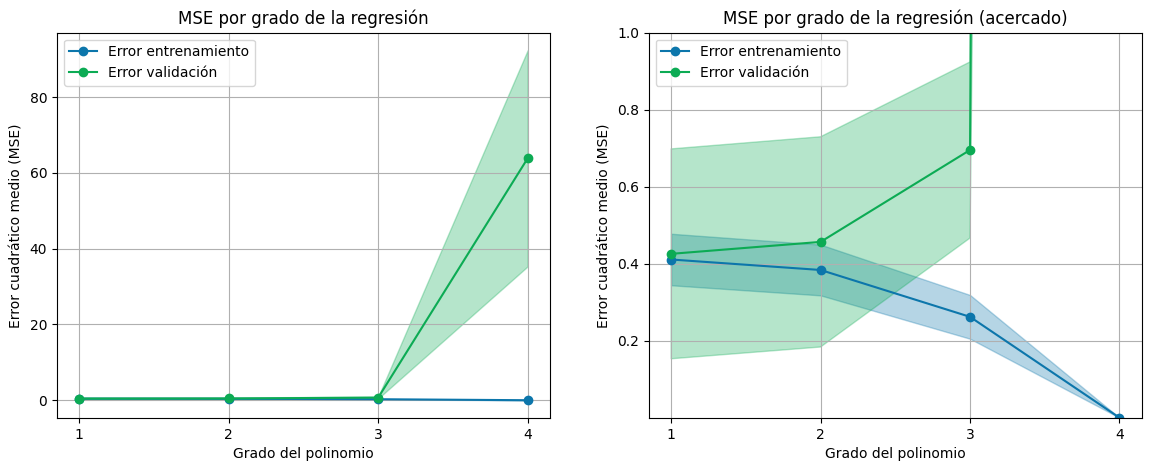

In [ ]:
plt.figure(figsize=(14, 5))
for i in range(1,3):
    plt.subplot(1,2,i)
    plt.plot(grados, train_mean, label="Error entrenamiento", marker="o", color="#0c76ab")
    plt.fill_between(
        grados,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.3,
        color="#0c76ab"
    )

    plt.plot(grados, val_mean, label="Error validación", marker="o", color="#0cab54")
    plt.fill_between(
        grados,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.3,
        color="#0cab54"
    )
    plt.xlabel("Grado del polinomio")
    plt.xticks(range(1,5))
    plt.ylabel("Error cuadrático medio (MSE)")
    title = 'MSE por grado de la regresión'
    if i == 2:
        plt.ylim([1e-5, 1])
        title += ' (acercado)'
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.show()

Se observa en las curvas de validación un claro efecto de sobreajuste cuando el grado de polinomio es 3 o más, el error de validación aumenta en gran medida mientras que el error de entrenamiento se acerca a cero.

Además se puede ver que la dispersión en los errores aumenta a medida que sube el grado del polinomio, mostrando un claro efecto que en modelos más complejos el error se asocia a la varianza (sensibilidad a cambios en la entrada) mientras que en modelos menos complejos el error se asocia al sesgo.

<a id="toc-evaluacion-del-mejor-modelo"></a>

### Evaluación del mejor modelo

In [21]:
mejor_modelo = pipeline_regresion.fit(x_train, y_train)
y_test_pred = mejor_modelo.predict(x_test)
print(f'------ Mejor modelo - Resultados en test ----')
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f'R²: {r2_score(y_test, y_test_pred):.2f}')

------ Mejor modelo - Resultados en test ----
RMSE: 0.81
MAE: 0.31
R²: 0.90


<a id="toc-regresion-lineal-regularizada"></a>
## Regresión lineal regularizada


<a id="toc-ridge-regularizacion-l2"></a>
### Ridge (Regularización L2)

A continuación se creara un Pipeline independiente para no modificar el pipeline de las actividades anteriores. Se exploran distintos valores de `alpha` y distintas estrategias de escalamiento, ya que Ridge es sensible a la escala de las variables.


In [23]:
numeric_transformer_ridge = Pipeline(steps=[
    ('rangos', rangos_validos),
    ('imputer', imputer_transformer),
    ('dropper_vif', dropper_vif),
    ('scaler', MinMaxScaler()),
])

preprocessing_ridge = ColumnTransformer(transformers=[
    ('binary', binary_transformer,  binary_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('numeric', numeric_transformer_ridge, numeric_features)
])

pipeline_ridge = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocesamiento', preprocessing_ridge),
    ('modelo', Ridge())
])

Antes de definir el grid de búsqueda, se realiza una exploración preliminar con `RidgeCV`, que evalúa automáticamente un rango amplio de valores de alpha mediante validación cruzada interna para no usar una escala arbitraria.. 


In [24]:
x_train_prep_ridge = pipeline_ridge[:-1].fit_transform(x_train, y_train)

alphas_candidatos = np.logspace(-4, 4, 100)
ridge_cv_explore = RidgeCV(alphas=alphas_candidatos, cv=kfold)
ridge_cv_explore.fit(x_train_prep_ridge, y_train)

alpha_sugerido_ridge = ridge_cv_explore.alpha_
print(f"Alpha sugerido: {alpha_sugerido_ridge:.4f}")

Alpha sugerido: 0.0464


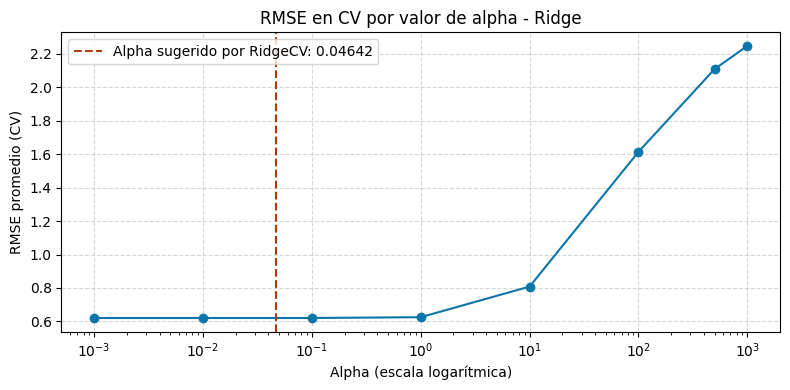


Rango del grid definido para incluir el alpha sugerido (0.0464):
modelo__alpha: [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]


In [25]:
rmse_por_alpha = []
for a in [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]:
    scores = cross_val_score(
        Ridge(alpha=a), x_train_prep_ridge, y_train,
        cv=5, scoring='neg_root_mean_squared_error'
    )
    rmse_por_alpha.append(-scores.mean())

alphas_grid_viz = [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]
plt.figure(figsize=(8, 4))
plt.plot(alphas_grid_viz, rmse_por_alpha, marker='o', color='#0c76ab')
plt.axvline(alpha_sugerido_ridge, color='#ab3b0c', linestyle='--',
            label=f'Alpha sugerido por RidgeCV: {alpha_sugerido_ridge:.5f}')
plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('RMSE promedio (CV)')
plt.title('RMSE en CV por valor de alpha - Ridge')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"\nRango del grid definido para incluir el alpha sugerido ({alpha_sugerido_ridge:.4f}):")
print("modelo__alpha: [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]")

In [26]:
param_grid_ridge = {
    "preprocesamiento__numeric__scaler": [
        MinMaxScaler(),
        Pipeline([
            ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)),
            ('scaler', StandardScaler())
        ]),
        StandardScaler()
    ],
    "modelo__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]
}

grid_ridge = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_grid_ridge,
    cv=kfold,
    scoring=scoring,
    refit='RMSE',
    return_train_score=True,
    n_jobs=-1
)

In [27]:
%%time
grid_ridge.fit(x_train, y_train)

CPU times: total: 1.02 s
Wall time: 1.77 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...o', Ridge())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'modelo__alpha': [0.001, 0.01, ...], 'preprocesamiento__numeric__scaler': [MinMaxScaler(), Pipeline(step...ardScaler())]), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'RMSE'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n

In [28]:
# Resultados Ridge ordenados por mejor RMSE
resultados_ridge = pd.DataFrame(grid_ridge.cv_results_)
resultados_ridge = resultados_ridge.rename(columns={
    'param_preprocesamiento__numeric__scaler': 'Scaler',
    'param_modelo__alpha': 'Alpha',
})
resultados_ridge[[
    "Scaler", "Alpha",
    "mean_test_RMSE", "std_test_RMSE",
    "mean_test_MAE", "std_test_MAE",
    "mean_test_R2", "std_test_R2"
]].sort_values("mean_test_RMSE", ascending=False)

,Scaler,Alpha,mean_test_RMSE,std_test_RMSE,mean_test_MAE,std_test_MAE,mean_test_R2,std_test_R2
3,MinMaxScaler(),0.010,-0.642897,0.122940,-0.260517,0.011101,0.930461,0.026110
0,MinMaxScaler(),0.001,-0.642899,0.122944,-0.260257,0.011127,0.930461,0.026110
2,StandardScaler(),0.001,-0.642899,0.122944,-0.260229,0.011129,0.930461,0.026110
5,StandardScaler(),0.010,-0.642900,0.122940,-0.260238,0.011126,0.930461,0.026109
8,StandardScaler(),0.100,-0.642904,0.122904,-0.260323,0.011091,0.930461,0.026103
6,MinMaxScaler(),0.100,-0.642916,0.122896,-0.263246,0.010886,0.930460,0.026108
11,StandardScaler(),1.000,-0.642971,0.122544,-0.261252,0.010780,0.930462,0.026034
14,StandardScaler(),10.000,-0.645666,0.118730,-0.274943,0.009384,0.930050,0.025395
9,MinMaxScaler(),1.000,-0.646352,0.121875,-0.293397,0.010251,0.929786,0.026118
1,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",0.001,-0.740277,0.121022,-0.404005,0.019399,0.908494,0.029914


In [29]:
print("Mejor configuración Ridge:", grid_ridge.best_params_)
print(f"Mejor RMSE (CV): {-grid_ridge.best_score_:.4f}")

Mejor configuración Ridge: {'modelo__alpha': 0.01, 'preprocesamiento__numeric__scaler': MinMaxScaler()}
Mejor RMSE (CV): 0.6429


In [30]:
# Evaluación del mejor Ridge en test
y_pred_ridge = grid_ridge.best_estimator_.predict(x_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("------ Ridge - Resultados en test ------")
print(f"RMSE: {rmse_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")
print(f"R²: {r2_ridge:.4f}")

------ Ridge - Resultados en test ------
RMSE: 0.8097
MAE: 0.3117
R²: 0.8970


<a id="toc-analisis-de-coeficientes-ridge"></a>
#### Análisis de coeficientes Ridge

Ahora visualizamos la magnitud de los coeficietes para entender qué variables tienen mayor peso en el modelo final.


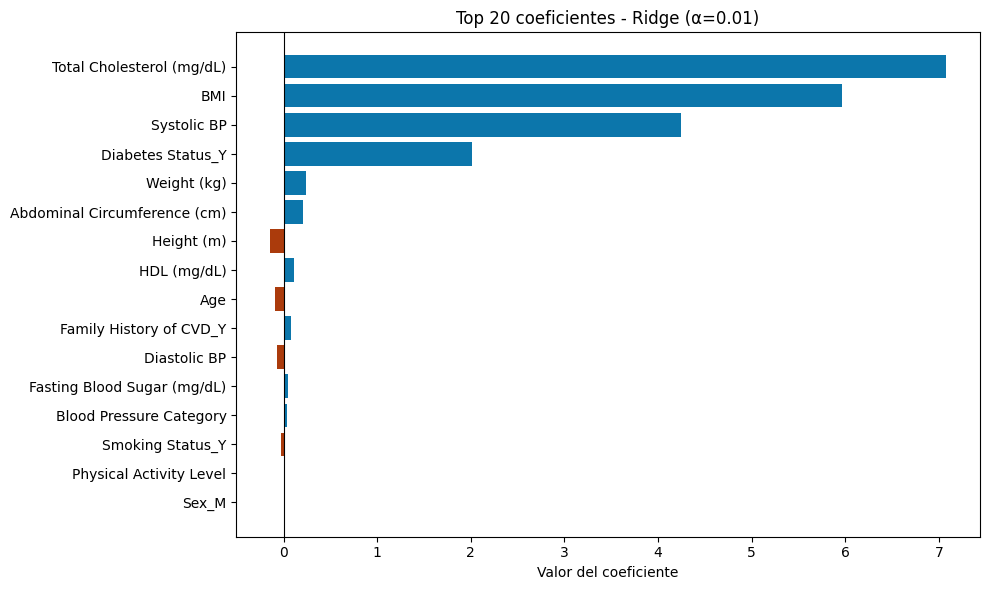

In [31]:
best_ridge = grid_ridge.best_estimator_

names_binary = best_ridge['preprocesamiento'].named_transformers_['binary']['onehot'].get_feature_names_out(binary_features).tolist()

names_ordinal = ordinal_features

columns_after_vif = [c for c in (median_columns + mean_columns + corr_features)
                     if c not in columns_vif]
names_numeric = columns_after_vif

feature_names_ridge = names_binary + names_ordinal + names_numeric
coefs_ridge = best_ridge['modelo'].coef_

coef_df_ridge = pd.DataFrame({
    'Feature':     feature_names_ridge,
    'Coeficiente': coefs_ridge
}).sort_values('Coeficiente', key=abs, ascending=False)

# Graficamos los 20 coeficientes más relevantes
top_n = 20
top_ridge = coef_df_ridge.head(top_n)
colors = ['#0c76ab' if c > 0 else '#ab3b0c' for c in top_ridge['Coeficiente']]

plt.figure(figsize=(10, 6))
plt.barh(top_ridge['Feature'], top_ridge['Coeficiente'], color=colors)
plt.xlabel('Valor del coeficiente')
plt.title(f'Top {top_n} coeficientes - Ridge (\u03b1={grid_ridge.best_params_["modelo__alpha"]})')
plt.axvline(0, color='black', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<a id="toc-lasso-regularizacion-l1"></a>
### Lasso (Regularización L1)

Para la regularización Lasso se exploran los mismos rangos de `alpha` y estrategias de escalamiento que en Ridge para hacer la comparación justa.


In [32]:
numeric_transformer_lasso = Pipeline(steps=[
    ('rangos', rangos_validos),
    ('imputer', imputer_transformer),
    ('dropper_vif', dropper_vif),
    ('scaler', MinMaxScaler()),
])

preprocessing_lasso = ColumnTransformer(transformers=[
    ('binary', binary_transformer,  binary_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('numeric', numeric_transformer_lasso, numeric_features)
])

pipeline_lasso = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocesamiento', preprocessing_lasso),
    ('modelo', Lasso(max_iter=10000))
])

Se repite el mismo procedimiento para Lasso usando `LassoCV`, que además de sugerir el alpha óptimo muestra cuántas variables son llevadas a cero para cada nivel de penalización. Esto permite ajustar el rango del grid a los valores donde Lasso produce soluciones útiles.


In [33]:
x_train_prep_lasso = pipeline_lasso[:-1].fit_transform(x_train, y_train)

alphas_lasso_candidatos = np.logspace(-5, 2, 50)
lasso_cv_explore = LassoCV(alphas=alphas_lasso_candidatos, cv=5, max_iter=20000)
lasso_cv_explore.fit(x_train_prep_lasso, y_train)

alpha_sugerido_lasso = lasso_cv_explore.alpha_
n_zero_sugerido = np.sum(lasso_cv_explore.coef_ == 0)
n_total_feats = len(lasso_cv_explore.coef_)

print(f"Alpha sugerido por LassoCV: {alpha_sugerido_lasso:.6f}")
print(f"Variables en cero con ese alpha: {n_zero_sugerido} de {n_total_feats} ({100*n_zero_sugerido/n_total_feats:.1f}%)")

Alpha sugerido por LassoCV: 0.002683
Variables en cero con ese alpha: 3 de 16 (18.8%)


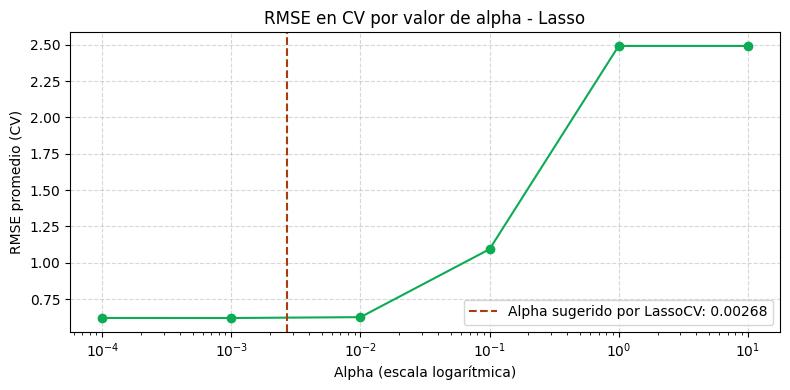


Rango del grid definido para incluir el alpha sugerido (0.00268):
modelo__alpha: [0.0001, 0.001, 0.01, 0.1, 1, 10]


In [34]:
# Visualizamos RMSE por alpha para el rango del grid de Lasso
alphas_lasso_viz = [0.0001, 0.001, 0.01, 0.1, 1, 10]
rmse_lasso_viz = []
for a in alphas_lasso_viz:
    scores = cross_val_score(
        Lasso(alpha=a, max_iter=20000), x_train_prep_lasso, y_train,
        cv=5, scoring='neg_root_mean_squared_error'
    )
    rmse_lasso_viz.append(-scores.mean())

plt.figure(figsize=(8, 4))
plt.plot(alphas_lasso_viz, rmse_lasso_viz, marker='o', color='#0cab54')
plt.axvline(alpha_sugerido_lasso, color='#ab3b0c', linestyle='--',
            label=f'Alpha sugerido por LassoCV: {alpha_sugerido_lasso:.5f}')
plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('RMSE promedio (CV)')
plt.title('RMSE en CV por valor de alpha - Lasso')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"\nRango del grid definido para incluir el alpha sugerido ({alpha_sugerido_lasso:.5f}):")
print("modelo__alpha: [0.0001, 0.001, 0.01, 0.1, 1, 10]")

In [35]:
param_grid_lasso = {
    "preprocesamiento__numeric__scaler": [
        MinMaxScaler(),
        Pipeline([
            ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)),
            ('scaler', StandardScaler())
        ]),
        StandardScaler()
    ],
    "modelo__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=param_grid_lasso,
    cv=5,
    scoring=scoring,
    refit='RMSE',
    return_train_score=True,
    n_jobs=-1
)

In [36]:
%%time
grid_lasso.fit(x_train, y_train)

CPU times: total: 766 ms
Wall time: 1.58 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...iter=10000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'modelo__alpha': [0.0001, 0.001, ...], 'preprocesamiento__numeric__scaler': [MinMaxScaler(), Pipeline(step...ardScaler())]), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'RMSE'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"ver

In [37]:
# Resultados Lasso
resultados_lasso = pd.DataFrame(grid_lasso.cv_results_)
resultados_lasso = resultados_lasso.rename(columns={
    'param_preprocesamiento__numeric__scaler': 'Scaler',
    'param_modelo__alpha': 'Alpha',
})
resultados_lasso[[
    "Scaler", "Alpha",
    "mean_test_RMSE", "std_test_RMSE",
    "mean_test_MAE", "std_test_MAE",
    "mean_test_R2", "std_test_R2"
]].sort_values("mean_test_RMSE", ascending=False)

,Scaler,Alpha,mean_test_RMSE,std_test_RMSE,mean_test_MAE,std_test_MAE,mean_test_R2,std_test_R2
8,StandardScaler(),0.0100,-0.618206,0.203390,-0.255898,0.053142,0.933597,0.040080
5,StandardScaler(),0.0010,-0.619806,0.202558,-0.259947,0.051706,0.933334,0.040099
3,MinMaxScaler(),0.0010,-0.619828,0.202745,-0.260926,0.051331,0.933320,0.040120
0,MinMaxScaler(),0.0001,-0.620168,0.202542,-0.260991,0.051648,0.933265,0.040124
2,StandardScaler(),0.0001,-0.620173,0.202524,-0.260916,0.051683,0.933265,0.040122
6,MinMaxScaler(),0.0100,-0.625561,0.202670,-0.291178,0.052537,0.932184,0.040064
11,StandardScaler(),0.1000,-0.676187,0.187203,-0.382363,0.055112,0.922444,0.038857
7,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",0.0100,-0.717038,0.227594,-0.404661,0.059559,0.911441,0.048308
4,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",0.0010,-0.718023,0.226927,-0.405767,0.058272,0.911281,0.048288
1,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",0.0001,-0.718257,0.226826,-0.406087,0.058082,0.911236,0.048289


In [38]:
print("Mejor configuración Lasso:", grid_lasso.best_params_)
print(f"Mejor RMSE (CV): {-grid_lasso.best_score_:.4f}")

Mejor configuración Lasso: {'modelo__alpha': 0.01, 'preprocesamiento__numeric__scaler': StandardScaler()}
Mejor RMSE (CV): 0.6182


In [39]:
# Evaluación del mejor Lasso en test
y_pred_lasso = grid_lasso.best_estimator_.predict(x_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("------ Lasso - Resultados en test ------")
print(f"RMSE: {rmse_lasso:.4f}")
print(f"MAE: {mae_lasso:.4f}")
print(f"R²: {r2_lasso:.4f}")

------ Lasso - Resultados en test ------
RMSE: 0.8072
MAE: 0.3067
R²: 0.8977


<a id="toc-analisis-de-coeficientes-lasso"></a>
#### Análisis de coeficientes Lasso


In [40]:
best_lasso = grid_lasso.best_estimator_

names_binary_l  = best_lasso['preprocesamiento'].named_transformers_['binary']['onehot'].get_feature_names_out(binary_features).tolist()
names_ordinal_l = ordinal_features
names_numeric_l = [c for c in (median_columns + mean_columns + corr_features)
                   if c not in columns_vif]

feature_names_lasso = names_binary_l + names_ordinal_l + names_numeric_l
coefs_lasso = best_lasso['modelo'].coef_

coef_df_lasso = pd.DataFrame({
    'Feature': feature_names_lasso,
    'Coeficiente': coefs_lasso
})

# Variables eliminadas (coeficiente exactamente 0)
eliminadas = coef_df_lasso[coef_df_lasso['Coeficiente'] == 0]
retenidas = coef_df_lasso[coef_df_lasso['Coeficiente'] != 0].sort_values('Coeficiente', key=abs, ascending=False)

print(f"Variables totales : {len(coef_df_lasso)}")
print(f"Variables retenidas : {len(retenidas)}")
print(f"Variables eliminadas: {len(eliminadas)}")
print(f"\nVariables eliminadas por Lasso:")
print(eliminadas['Feature'].tolist())

Variables totales : 16
Variables retenidas : 13
Variables eliminadas: 3

Variables eliminadas por Lasso:
['Sex_M', 'Smoking Status_Y', 'Diastolic BP']


Estas variables no aportan información adicional al modelo. Esto pasa porque su efecto ya está siendo capturado por otras variables correlacionadas. Por ejemplo, **Sex_M** puede estar reflejado indirectamente en variables como IMC o colesterol, y **Smoking Status_Y** en variables como glucosa o presión sistólica, por lo que Lasso elimina una para evitar redundancia. Esto no significa que no sean importantes clínicamente, sino que en este dataset no aportan información nueva al modelo.


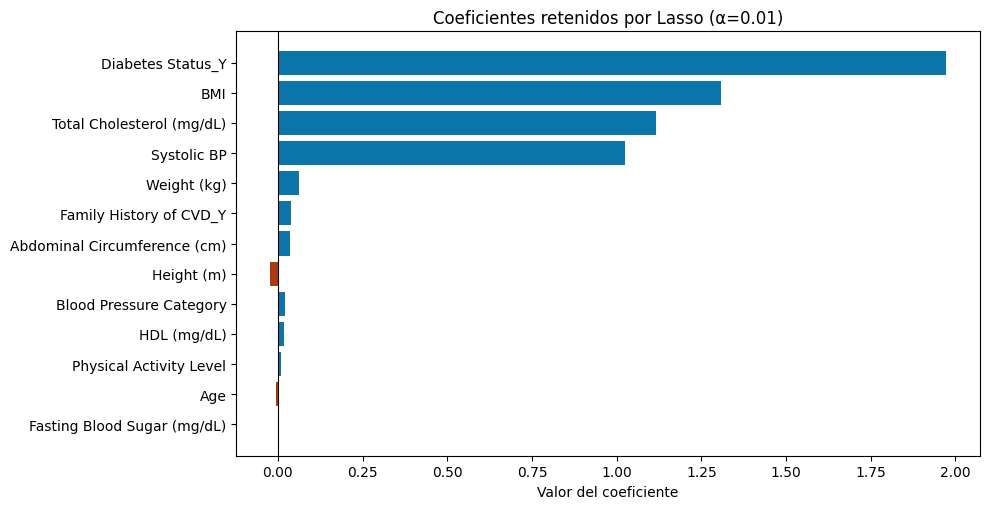

In [41]:
# Graficamos variables retenidas por Lasso
colors_lasso = ['#0c76ab' if c > 0 else '#ab3b0c' for c in retenidas['Coeficiente']]

plt.figure(figsize=(10, max(5, len(retenidas) * 0.4)))
plt.barh(retenidas['Feature'], retenidas['Coeficiente'], color=colors_lasso)
plt.xlabel('Valor del coeficiente')
plt.title(f'Coeficientes retenidos por Lasso (\u03b1={grid_lasso.best_params_["modelo__alpha"]})')
plt.axvline(0, color='black', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<a id="toc-comparacion-sin-regularizacion-vs-ridge-vs-lasso"></a>
### Comparación: Sin regularización vs Ridge vs Lasso

Se comparan las métricas obtenidas en validación cruzada y en test para los tres modelos, analizando el efecto de la penalización sobre la generalización y la magnitud de los coeficientes.


In [42]:
resultados_cv = pd.DataFrame(grid.cv_results_)
mask_g1 = resultados_cv['param_preprocesamiento__numeric__polynomial__degree'] == 1
mejor_lineal_cv = resultados_cv[mask_g1].sort_values('mean_test_RMSE', ascending=False).iloc[0]

y_pred_lineal = grid.best_estimator_.predict(x_test)

comparacion = pd.DataFrame({
    'Modelo': ['Regresión Lineal (sin reg.)', 'Ridge (L2)', 'Lasso (L1)'],
    'RMSE CV (promedio)': [
        -mejor_lineal_cv['mean_test_RMSE'],
        -grid_ridge.best_score_,
        -grid_lasso.best_score_
    ],
    'RMSE CV (std)': [
        mejor_lineal_cv['std_test_RMSE'],
        grid_ridge.cv_results_['std_test_RMSE'][grid_ridge.best_index_],
        grid_lasso.cv_results_['std_test_RMSE'][grid_lasso.best_index_]
    ],
    'RMSE Test': [
        np.sqrt(mean_squared_error(y_test, y_pred_lineal)),
        rmse_ridge,
        rmse_lasso
    ],
    'MAE Test': [
        mean_absolute_error(y_test, y_pred_lineal),
        mae_ridge,
        mae_lasso
    ],
    'R\u00b2 Test': [
        r2_score(y_test, y_pred_lineal),
        r2_ridge,
        r2_lasso
    ],
    'Coefs. en cero': [0, 0, len(eliminadas)]
})

comparacion

,Modelo,RMSE CV (promedio),RMSE CV (std),RMSE Test,MAE Test,R² Test,Coefs. en cero
0,Regresión Lineal (sin reg.),0.642899,0.122944,0.809740,0.311474,0.897024,0
1,Ridge (L2),0.642897,0.122940,0.809724,0.311734,0.897028,0
2,Lasso (L1),0.618206,0.203390,0.807240,0.306746,0.897659,3


<a id="toc-regresion-polinomial-regularizada"></a>
## Regresión polinomial regularizada


<a id="toc-pipeline-de-regresion-polinomial-ridge"></a>
### Pipeline de regresión polinomial Ridge


In [43]:
numeric_transformer_poly_ridge = Pipeline(steps=[
    ('rangos', rangos_validos),
    ('imputer', imputer_transformer),
    ('dropper_vif', dropper_vif),
    ('scaler', MinMaxScaler()),
    ('polynomial', PolynomialFeatures(degree=1, include_bias=False))
])

preprocessing_poly_ridge = ColumnTransformer(transformers=[
    ('binary', binary_transformer,  binary_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('numeric', numeric_transformer_poly_ridge, numeric_features)
])

pipeline_poly_ridge = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocesamiento', preprocessing_poly_ridge),
    ('modelo', Ridge())
])

In [44]:
param_grid_poly_ridge = {
    "preprocesamiento__numeric__polynomial__degree": list(range(1, 5)),
    "preprocesamiento__numeric__scaler": [
        MinMaxScaler(),
        Pipeline([
            ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)),
            ('scaler', StandardScaler())
        ]),
        StandardScaler()
    ],
    "modelo__alpha": [0.01, 0.1, 1, 10, 100, 500, 1000]
}

grid_poly_ridge = GridSearchCV(
    estimator=pipeline_poly_ridge,
    param_grid=param_grid_poly_ridge,
    cv=kfold,
    scoring=scoring,
    refit='RMSE',
    return_train_score=True,
    n_jobs=-1
)

In [45]:
%%time
grid_poly_ridge.fit(x_train, y_train)

CPU times: total: 3.31 s
Wall time: 7.86 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...o', Ridge())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'modelo__alpha': [0.01, 0.1, ...], 'preprocesamiento__numeric__polynomial__degree': [1, 2, ...], 'preprocesamiento__numeric__scaler': [MinMaxScaler(), Pipeline(step...ardScaler())]), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'RMSE'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` d

In [46]:
# Resultados ordenados por RMSE
resultados_poly_ridge = pd.DataFrame(grid_poly_ridge.cv_results_)
resultados_poly_ridge = resultados_poly_ridge.rename(columns={
    'param_preprocesamiento__numeric__scaler': 'Scaler',
    'param_preprocesamiento__numeric__polynomial__degree': 'Degree',
    'param_modelo__alpha': 'Alpha',
})
resultados_poly_ridge[[
    "Degree", "Alpha", "Scaler",
    "mean_test_RMSE", "std_test_RMSE",
    "mean_test_MAE", "std_test_MAE",
    "mean_test_R2", "std_test_R2"
]].sort_values("mean_test_RMSE", ascending=False)

,Degree,Alpha,Scaler,mean_test_RMSE,std_test_RMSE,mean_test_MAE,std_test_MAE,mean_test_R2,std_test_R2
0,1,0.01,MinMaxScaler(),-0.642897,0.122940,-0.260517,0.011101,0.930461,0.026110
2,1,0.01,StandardScaler(),-0.642900,0.122940,-0.260238,0.011126,0.930461,0.026109
14,1,0.10,StandardScaler(),-0.642904,0.122904,-0.260323,0.011091,0.930461,0.026103
12,1,0.10,MinMaxScaler(),-0.642916,0.122896,-0.263246,0.010886,0.930460,0.026108
26,1,1.00,StandardScaler(),-0.642971,0.122544,-0.261252,0.010780,0.930462,0.026034
...,...,...,...,...,...,...,...,...,...
34,4,1.00,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",-4.097354,1.004853,-2.328999,0.334050,-1.917545,1.533954
23,4,0.10,StandardScaler(),-5.955483,1.172389,-3.534525,0.632013,-4.905013,2.180411
22,4,0.10,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",-6.127810,1.594762,-3.362873,0.600107,-5.571641,3.504750
11,4,0.01,StandardScaler(),-6.711181,1.398771,-3.956029,0.808842,-6.550908,2.963899


In [47]:
print("Mejor configuración (Poly + Ridge):", grid_poly_ridge.best_params_)
print(f"Mejor RMSE (CV): {-grid_poly_ridge.best_score_:.4f}")

Mejor configuración (Poly + Ridge): {'modelo__alpha': 0.01, 'preprocesamiento__numeric__polynomial__degree': 1, 'preprocesamiento__numeric__scaler': MinMaxScaler()}
Mejor RMSE (CV): 0.6429


In [48]:
# Evaluación en test
y_pred_poly_ridge = grid_poly_ridge.best_estimator_.predict(x_test)

rmse_poly_ridge = np.sqrt(mean_squared_error(y_test, y_pred_poly_ridge))
mae_poly_ridge = mean_absolute_error(y_test, y_pred_poly_ridge)
r2_poly_ridge = r2_score(y_test, y_pred_poly_ridge)

print("------ Polinomial + Ridge - Resultados en test ------")
print(f"RMSE: {rmse_poly_ridge:.4f}")
print(f"MAE: {mae_poly_ridge:.4f}")
print(f"R²: {r2_poly_ridge:.4f}")

------ Polinomial + Ridge - Resultados en test ------
RMSE: 0.8097
MAE: 0.3117
R²: 0.8970


<a id="toc-analisis-del-efecto-de-la-regularizacion"></a>
### Análisis del efecto de la regularización

Para entender cómo interactúan el grado del polinomio y el parámetro `alpha`, graficamos el RMSE en validación cruzada en función del grado del polinomio, para distintos valores de alpha. Esto permite ver si la regularización efectivamente "amortigua" el sobreajuste que aparece al aumentar el grado.


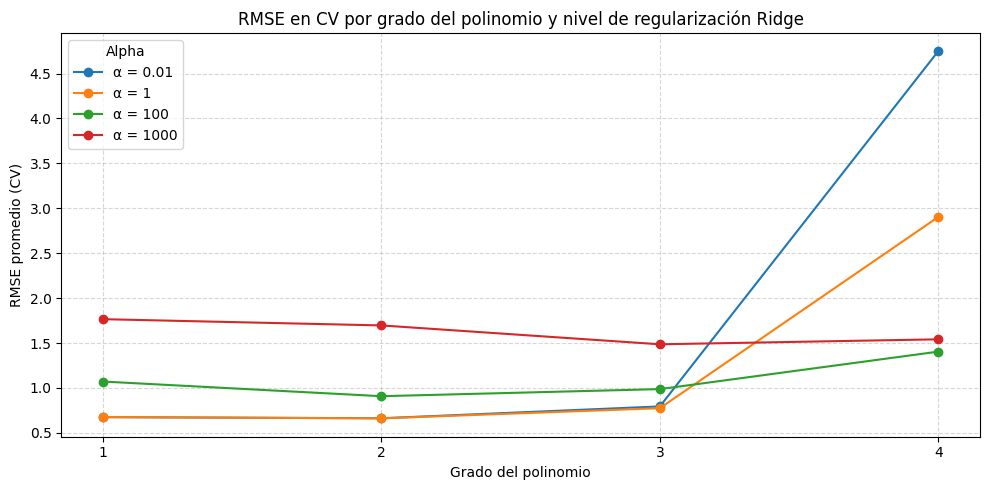

In [49]:
# RMSE CV por grado y alpha para el modelo Poly + Ridge
resultados_pr = resultados_poly_ridge.copy()
resultados_pr['mean_test_RMSE'] = resultados_pr['mean_test_RMSE'].abs()

alphas_plot = [0.01, 1, 100, 1000]
grados_plot = list(range(1, 5))

plt.figure(figsize=(10, 5))
for alpha_val in alphas_plot:
    subset = resultados_pr[resultados_pr['Alpha'] == alpha_val]
    grouped = subset.groupby('Degree')['mean_test_RMSE'].mean().reset_index()
    plt.plot(grouped['Degree'], grouped['mean_test_RMSE'],
             marker='o', label=f'α = {alpha_val}')

plt.xlabel('Grado del polinomio')
plt.xticks(grados_plot)
plt.ylabel('RMSE promedio (CV)')
plt.title('RMSE en CV por grado del polinomio y nivel de regularización Ridge')
plt.legend(title='Alpha')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

La gráfica muestra cómo la regularización controla el sobreajuste cuando aumenta el grado del polinomio. Con **alpha bajo (0.01)**, el error crece en grado 4, lo que indica sobreajuste porque el modelo se vuelve demasiado flexible. Con **alpha moderado (1)** pasa algo similar pero menos marcado.

En cambio, con **alpha alto (100 y 1000)** el error se mantiene más estable, porque la regularización limita los coeficientes y evita el sobreajuste. Sin embargo, con **alpha=1000** el error incial es más alto, lo que indica subajuste porque el modelo está demasiado restringido. 


<a id="toc-pipeline-de-regresion-polinomial-lasso"></a>
### Pipeline de regresión polinomial Lasso


In [50]:
numeric_transformer_poly_lasso = Pipeline(steps=[
    ('rangos', rangos_validos),
    ('imputer', imputer_transformer),
    ('dropper_vif', dropper_vif),
    ('scaler', MinMaxScaler()),
    ('polynomial', PolynomialFeatures(degree=1, include_bias=False))
])

preprocessing_poly_lasso = ColumnTransformer(transformers=[
    ('binary', binary_transformer,  binary_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('numeric', numeric_transformer_poly_lasso, numeric_features)
])

pipeline_poly_lasso = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocesamiento', preprocessing_poly_lasso),
    ('modelo', Lasso(max_iter=20000))
])

In [51]:
param_grid_poly_lasso = {
    "preprocesamiento__numeric__polynomial__degree": list(range(1, 5)),
    "preprocesamiento__numeric__scaler": [
        MinMaxScaler(),
        Pipeline([
            ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)),
            ('scaler', StandardScaler())
        ]),
        StandardScaler()
    ],
    "modelo__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

grid_poly_lasso = GridSearchCV(
    estimator=pipeline_poly_lasso,
    param_grid=param_grid_poly_lasso,
    cv=kfold,
    scoring=scoring,
    refit='RMSE',
    return_train_score=True,
    n_jobs=-1
)

In [52]:
%%time
grid_poly_lasso.fit(x_train, y_train)

CPU times: total: 9.81 s
Wall time: 2min 3s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...iter=20000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'modelo__alpha': [0.0001, 0.001, ...], 'preprocesamiento__numeric__polynomial__degree': [1, 2, ...], 'preprocesamiento__numeric__scaler': [MinMaxScaler(), Pipeline(step...ardScaler())]), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'RMSE'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv``

In [53]:
print("Mejor configuración (Poly + Lasso):", grid_poly_lasso.best_params_)
print(f"Mejor RMSE (CV): {-grid_poly_lasso.best_score_:.4f}")

Mejor configuración (Poly + Lasso): {'modelo__alpha': 0.001, 'preprocesamiento__numeric__polynomial__degree': 4, 'preprocesamiento__numeric__scaler': MinMaxScaler()}
Mejor RMSE (CV): 0.6403


In [54]:
# Evaluación en test
y_pred_poly_lasso = grid_poly_lasso.best_estimator_.predict(x_test)

rmse_poly_lasso = np.sqrt(mean_squared_error(y_test, y_pred_poly_lasso))
mae_poly_lasso = mean_absolute_error(y_test, y_pred_poly_lasso)
r2_poly_lasso = r2_score(y_test, y_pred_poly_lasso)

print("\n------ Polinomial + Lasso - Resultados en test ------")
print(f"RMSE: {rmse_poly_lasso:.4f}")
print(f"MAE: {mae_poly_lasso:.4f}")
print(f"R²: {r2_poly_lasso:.4f}")


------ Polinomial + Lasso - Resultados en test ------
RMSE: 0.8077
MAE: 0.3188
R²: 0.8976


In [55]:
best_poly_lasso = grid_poly_lasso.best_estimator_

poly_step = best_poly_lasso['preprocesamiento'].named_transformers_['numeric']['polynomial']
numeric_cols_after_vif = [c for c in (median_columns + mean_columns + corr_features)
                          if c not in columns_vif]
names_poly_numeric = poly_step.get_feature_names_out(numeric_cols_after_vif).tolist()

names_binary_pl  = best_poly_lasso['preprocesamiento'].named_transformers_['binary']['onehot'].get_feature_names_out(binary_features).tolist()
names_ordinal_pl = ordinal_features

feature_names_poly_lasso = names_binary_pl + names_ordinal_pl + names_poly_numeric
coefs_poly_lasso = best_poly_lasso['modelo'].coef_

n_total = len(coefs_poly_lasso)
n_cero = np.sum(coefs_poly_lasso == 0)
n_retenidos = n_total - n_cero

print(f"Features totales generadas por el polinomio: {n_total}")
print(f"Features llevadas a cero por Lasso: {n_cero} ({100*n_cero/n_total:.1f}%)")
print(f"Features retenidas: {n_retenidos} ({100*n_retenidos/n_total:.1f}%)")

Features totales generadas por el polinomio: 1006
Features llevadas a cero por Lasso: 963 (95.7%)
Features retenidas: 43 (4.3%)


<a id="toc-analisis-del-efecto-de-la-regularizacion-1"></a>
### Análisis del efecto de la regularización

Para entender cómo interactúan el grado del polinomio y el parámetro `alpha`, graficamos el RMSE en validación cruzada en función del grado del polinomio, para distintos valores de alpha. Esto permite ver si la regularización efectivamente "amortigua" el sobreajuste que aparece al aumentar el grado.


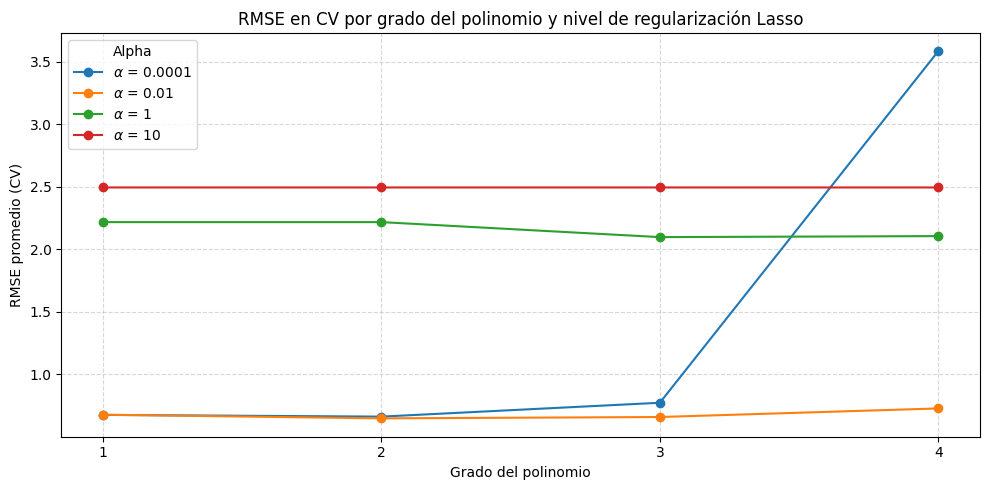

In [56]:
resultados_pl = pd.DataFrame(grid_poly_lasso.cv_results_)
resultados_pl = resultados_pl.rename(columns={
    'param_preprocesamiento__numeric__scaler': 'Scaler',
    'param_preprocesamiento__numeric__polynomial__degree': 'Degree',
    'param_modelo__alpha': 'Alpha',
})
resultados_pl['mean_test_RMSE'] = resultados_pl['mean_test_RMSE'].abs()

alphas_plot_lasso = [0.0001, 0.01, 1, 10]
grados_plot = list(range(1, 5))

plt.figure(figsize=(10, 5))
for alpha_val in alphas_plot_lasso:
    subset = resultados_pl[resultados_pl['Alpha'] == alpha_val]
    grouped = subset.groupby('Degree')['mean_test_RMSE'].mean().reset_index()
    plt.plot(grouped['Degree'], grouped['mean_test_RMSE'],
             marker='o', label=fr'$\alpha$ = {alpha_val}')

plt.xlabel('Grado del polinomio')
plt.xticks(grados_plot)
plt.ylabel('RMSE promedio (CV)')
plt.title('RMSE en CV por grado del polinomio y nivel de regularización Lasso')
plt.legend(title='Alpha')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

La gráfica muestra que con **alpha alto (10 y 1)** el RMSE se mantiene casi plano, lo que indica subajuste, porque Lasso penaliza tanto que elimina la mayoría de los términos polinomiales y el modelo no aprovecha la mayor complejidad.

En cambio, con **alpha muy bajo (0.0001)** el error aumenta mucho en grado 4, señal de sobreajuste, porque la regularización no es suficiente para controlar los nuevos términos. El mejor resultado se da con **alpha=0.01**, donde el RMSE se mantiene bajo y estable, lo que indica que Lasso logra un buen equilibrio entre evitar el sobreajuste y mantener su capacidad predictiva.


<a id="toc-comparacion-polinomial-sin-regularizacion-vs-polinomial-ridge-vs-polinomial-lasso"></a>
### Comparación: polinomial sin regularización vs polinomial Ridge vs polinomial Lasso

Se construye una tabla comparativa que muestra el efecto de agregar regularización al modelo polinomial, evaluando si la penalización logra controlar el sobreajuste al incrementar el grado.


In [57]:
rmse_poly_cv   = -grid.best_score_
std_poly_cv    = grid.cv_results_['std_test_RMSE'][grid.best_index_]
y_pred_poly    = grid.best_estimator_.predict(x_test)
best_degree_poly = grid.best_params_['preprocesamiento__numeric__polynomial__degree']

comparacion_act4 = pd.DataFrame({
    'Modelo': [
        f'Polinomial sin reg. (grado={best_degree_poly})',
        f'Polinomial + Ridge  (grado={grid_poly_ridge.best_params_["preprocesamiento__numeric__polynomial__degree"]}, α={grid_poly_ridge.best_params_["modelo__alpha"]})',
        f'Polinomial + Lasso  (grado={grid_poly_lasso.best_params_["preprocesamiento__numeric__polynomial__degree"]}, α={grid_poly_lasso.best_params_["modelo__alpha"]})'
    ],
    'RMSE CV (promedio)': [
        rmse_poly_cv,
        -grid_poly_ridge.best_score_,
        -grid_poly_lasso.best_score_
    ],
    'RMSE CV (std)': [
        std_poly_cv,
        grid_poly_ridge.cv_results_['std_test_RMSE'][grid_poly_ridge.best_index_],
        grid_poly_lasso.cv_results_['std_test_RMSE'][grid_poly_lasso.best_index_]
    ],
    'RMSE Test': [
        np.sqrt(mean_squared_error(y_test, y_pred_poly)),
        rmse_poly_ridge,
        rmse_poly_lasso
    ],
    'MAE Test': [
        mean_absolute_error(y_test, y_pred_poly),
        mae_poly_ridge,
        mae_poly_lasso
    ],
    'R² Test': [
        r2_score(y_test, y_pred_poly),
        r2_poly_ridge,
        r2_poly_lasso
    ]
})

comparacion_act4

,Modelo,RMSE CV (promedio),RMSE CV (std),RMSE Test,MAE Test,R² Test
0,Polinomial sin reg. (grado=1),0.642899,0.122944,0.809740,0.311474,0.897024
1,"Polinomial + Ridge (grado=1, α=0.01)",0.642897,0.122940,0.809724,0.311734,0.897028
2,"Polinomial + Lasso (grado=4, α=0.001)",0.640279,0.124407,0.807656,0.318844,0.897554


<a id="toc-comparacion-y-seleccion-del-mejor-modelo"></a>
## Comparación y selección del mejor modelo

Se consolidan los resultados de todos los modelos en una única tabla comparativa. La selección del mejor modelo considera tres criterios simultáneamente: **desempeño** (RMSE promedio en CV y en test), **estabilidad** (desviación estándar del RMSE en CV) y **complejidad** (número de variables, grado del polinomio, interpretabilidad).


In [58]:
tabla_final = pd.DataFrame({
    'Modelo': [
        'Lineal sin regularización',
        'Ridge (L2)',
        'Lasso (L1)',
        'Polinomial + Ridge  (grado=1, α=0.01)',
        'Polinomial + Lasso  (grado=4, α=0.001)',
    ],
    'RMSE CV (promedio)': [0.642899, 0.642897, 0.618206, 0.642897, 0.640279],
    'RMSE CV (std)': [0.122944, 0.122940, 0.203390, 0.122940, 0.124407],
    'RMSE Test': [0.809740, 0.809724, 0.807240, 0.809724, 0.807656],
    'MAE Test': [0.311474, 0.311734, 0.306746, 0.311734, 0.318844],
    'R² Test': [0.897024, 0.897028, 0.897659, 0.897028, 0.897554],
    'Grado': [1, 1, 1, 1, 4],
    'Coefs. en cero': [0, 0, 3, 0, 'N/A'],
})

tabla_final

,Modelo,RMSE CV (promedio),RMSE CV (std),RMSE Test,MAE Test,R² Test,Grado,Coefs. en cero
0,Lineal sin regularización,0.642899,0.122944,0.809740,0.311474,0.897024,1,0
1,Ridge (L2),0.642897,0.122940,0.809724,0.311734,0.897028,1,0
2,Lasso (L1),0.618206,0.203390,0.807240,0.306746,0.897659,1,3
3,"Polinomial + Ridge (grado=1, α=0.01)",0.642897,0.122940,0.809724,0.311734,0.897028,1,0
4,"Polinomial + Lasso (grado=4, α=0.001)",0.640279,0.124407,0.807656,0.318844,0.897554,4,N/A


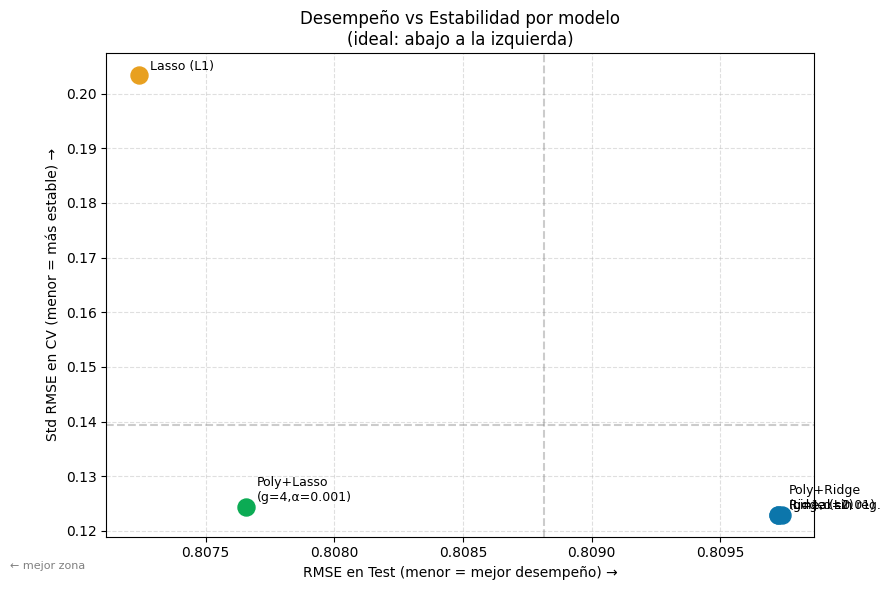

In [59]:
"""
GRAFICA GENERADA POR CLAUDE.AI
"""

# Gráfica 1: Scatter RMSE Test vs Std CV (desempeño vs estabilidad)
modelos_scatter = [
    'Lineal sin reg.',
    'Ridge (L2)',
    'Lasso (L1)',
    'Poly+Ridge\n(g=1,α=0.01)',
    'Poly+Lasso\n(g=4,α=0.001)',
]

rmse_test_vals = [0.809740, 0.809724, 0.807240, 0.809724, 0.807656]
std_cv_vals    = [0.122944, 0.122940, 0.203390, 0.122940, 0.124407]
colors_scatter = ['#0c76ab', '#0c76ab', '#e8a020', '#0c76ab', '#0cab54']

fig, ax = plt.subplots(figsize=(9, 6))
for i, (x, y, label, color) in enumerate(zip(rmse_test_vals, std_cv_vals, modelos_scatter, colors_scatter)):
    ax.scatter(x, y, s=150, color=color, zorder=5)
    ax.annotate(label, (x, y), textcoords="offset points",
                xytext=(8, 4), fontsize=9)

ax.set_xlabel('RMSE en Test (menor = mejor desempeño) →', fontsize=10)
ax.set_ylabel('Std RMSE en CV (menor = más estable) →', fontsize=10)
ax.set_title('Desempeño vs Estabilidad por modelo\n(ideal: abajo a la izquierda)')

# Anotación del cuadrante ideal
ax.axvline(np.mean(rmse_test_vals), color='gray', linestyle='--', alpha=0.4)
ax.axhline(np.mean(std_cv_vals),    color='gray', linestyle='--', alpha=0.4)
ax.text(min(rmse_test_vals) - 0.0005, min(std_cv_vals) - 0.01,
        '← mejor zona', fontsize=8, color='gray')

ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

<a id="toc-seleccion-del-mejor-modelo-y-justificacion"></a>
### Selección del mejor modelo y justificación

Los resultados muestran que **todos los modelos tienen un desempeño muy similar**, con RMSE entre 0.807 y 0.810 y R² cerca de 0.898. Esto sugiere que las relaciones en los datos son principalmente lineales y que agregar más complejidad no mejora mucho el rendimiento.

**Desempeño:** Lasso obtiene el mejor RMSE (0.8072) y MAE (0.3067), aunque la diferencia frente a los demás es mínima.

**Estabilidad:** Lasso tiene mayor variabilidad en validación cruzada, lo que indica que su rendimiento cambia más entre distintos folds.

**Complejidad:** Lasso es el más interpretable, ya que elimina variables irrelevantes y mantiene el modelo más simple sin perder rendimiento.


**Modelo seleccionado: Lasso (L1)**
Se elige Lasso porque logra el menor error, mantiene el modelo simple y permite identificar qué variables son realmente relevantes, sin sacrificar desempeño.


<a id="toc-entrenamiento-del-mejor-modelo"></a>
## Entrenamiento del mejor modelo


In [75]:
mejor_modelo_final = pipeline_lasso.set_params(modelo__alpha=0.01)
mejor_modelo_final.fit(x_train, y_train)
y_pred_lasso_simple = mejor_modelo_final.predict(x_test)
print(r"------ Regresión lineal con Lasso - Resultados en test ------")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso_simple)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso_simple):.4f}")
print(f"R²: {r2_score(y_test, y_pred_lasso_simple):.4f}")

------ Regresión lineal con Lasso - Resultados en test ------
RMSE: 0.8154
MAE: 0.3426
R²: 0.8956


<a id="toc-construccion-de-intervalos-de-confianza"></a>
## Construcción de intervalos de confianza


Esta sección implementa bootstrapping sobre el conjunto de test para cuantificar la incertidumbre de las métricas del modelo final seleccionado.

Se usan **1000 remuestreos** con reemplazo para estimar **IC del 95%** de RMSE, MAE y R^2, además de visualizar la distribución de errores y discutir estabilidad, variabilidad y confiabilidad.



In [64]:
modelo_boot = mejor_modelo_final  # definido previamente: Lasso (L1)

n_boot = 1000
rng = np.random.default_rng(42)

n_test = len(y_test)
rmse_bs, mae_bs, r2_bs = [], [], []
all_residuals_bs = []

for _ in range(n_boot):
    idx = rng.integers(0, n_test, size=n_test)
    x_b = x_test.iloc[idx]
    y_b = y_test.iloc[idx].to_numpy()
    y_pred_b = modelo_boot.predict(x_b)
    resid_b = y_b - y_pred_b
    rmse_bs.append(np.sqrt(mean_squared_error(y_b, y_pred_b)))
    mae_bs.append(mean_absolute_error(y_b, y_pred_b))
    r2_bs.append(r2_score(y_b, y_pred_b))
    all_residuals_bs.append(resid_b)


A partir de las pruebas bootstrap, podemos construir los intervalos de confianza de las métricas de RMSE, MAE y R², adicionalmente podremos ver las desviaciones de estas métricas en una tabla


In [65]:

rmse_bs = np.array(rmse_bs)
mae_bs = np.array(mae_bs)
r2_bs = np.array(r2_bs)
all_residuals_bs = np.concatenate(all_residuals_bs)

y_pred_test = modelo_boot.predict(x_test)
residuals_test = np.asarray(y_test) - y_pred_test
abs_err_test = np.abs(residuals_test)

rmse_point = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_point = mean_absolute_error(y_test, y_pred_test)
r2_point = r2_score(y_test, y_pred_test)

def ic95(x):
    return np.percentile(x, [2.5, 97.5])

rmse_ci = ic95(rmse_bs)
mae_ci = ic95(mae_bs)
r2_ci = ic95(r2_bs)


In [66]:

tabla_ic = pd.DataFrame({
    'Métrica': ['RMSE', 'MAE', 'R²'],
    'Estimación puntual (test)': [rmse_point, mae_point, r2_point],
    'IC 95% - Límite inferior': [rmse_ci[0], mae_ci[0], r2_ci[0]],
    'IC 95% - Límite superior': [rmse_ci[1], mae_ci[1], r2_ci[1]],
    'Desv. Est. bootstrap': [rmse_bs.std(ddof=1), mae_bs.std(ddof=1), r2_bs.std(ddof=1)]
})

print(f'Remuestreos bootstrap realizados: {n_boot}')
display(tabla_ic.style.format({
    'Estimación puntual (test)': '{:.4f}',
    'IC 95% - Límite inferior': '{:.4f}',
    'IC 95% - Límite superior': '{:.4f}',
    'Desv. Est. bootstrap': '{:.4f}'
}))

Remuestreos bootstrap realizados: 1000


,Métrica,Estimación puntual (test),IC 95% - Límite inferior,IC 95% - Límite superior,Desv. Est. bootstrap
0,RMSE,0.8154,0.4817,1.1614,0.1781
1,MAE,0.3426,0.2621,0.4471,0.0468
2,R²,0.8956,0.7981,0.9625,0.0445


En la tabla podemos observar que los resultados obtenidos por el modelo son confiables, esto se observa en los límites del intervalo de confianza, estos límites no se encuentran muy alejados de los resultados vistos y podemos garantizar con una confianza del 95% que las métricas proporcionadas se encuentran dentro de este intervalo, por otra parte, la desviación de las métricas nos indica una poca dispersión, es decir que estas variables tienden a comportarse de manera similar.


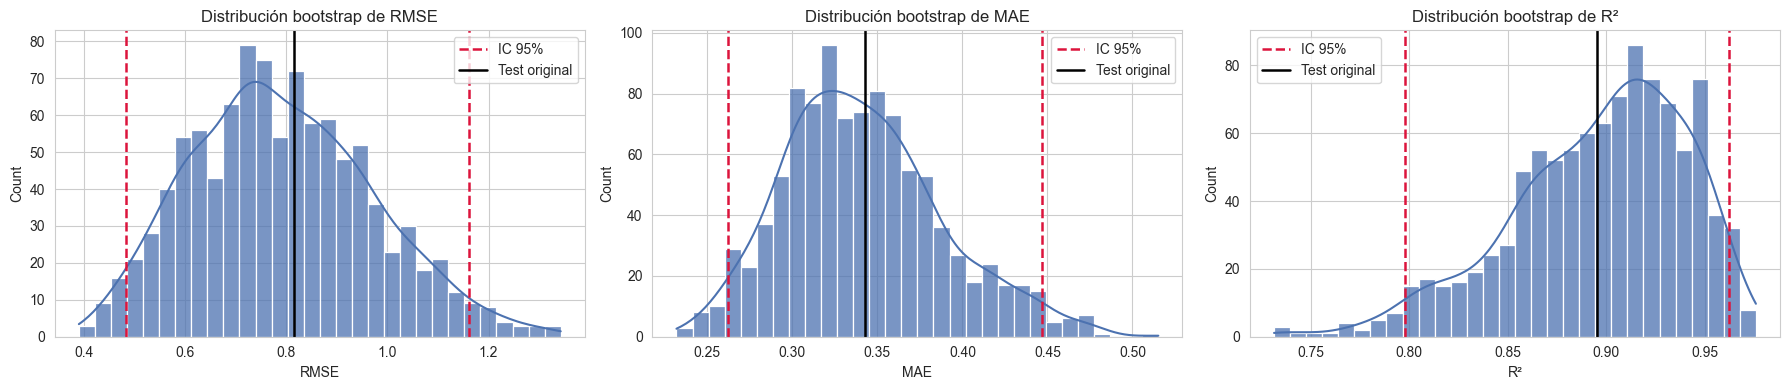

In [67]:
"""
GRAFICA GENERADA POR CLAUDE.AI
"""
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

metricas = [
    ('RMSE', rmse_bs, rmse_ci, rmse_point),
    ('MAE', mae_bs, mae_ci, mae_point),
    ('R²', r2_bs, r2_ci, r2_point)
]

for ax, (nombre, valores, ci, punto) in zip(axes, metricas):
    sns.histplot(valores, bins=30, kde=True, ax=ax, color='#4C72B0', alpha=0.75)
    ax.axvline(ci[0], color='crimson', linestyle='--', linewidth=1.8, label='IC 95%')
    ax.axvline(ci[1], color='crimson', linestyle='--', linewidth=1.8)
    ax.axvline(punto, color='black', linestyle='-', linewidth=1.8, label='Test original')
    ax.set_title(f'Distribución bootstrap de {nombre}')
    ax.set_xlabel(nombre)
    ax.legend()

plt.tight_layout()
plt.show()

Las distribuciones de las variables nos confirman la confiabilidad, y estabilidad del modelo pues en las métricas no se observan fuertes outliers que indiquen un deterioro claro en el comportamiento del modelo, y durante todas las muestras bootstrap se obtuvieron resultados acotados y similares, de hecho se observa que las distribuciones se inclinan hacia desempeños más favorables con menores errores y un mayor valor de R²


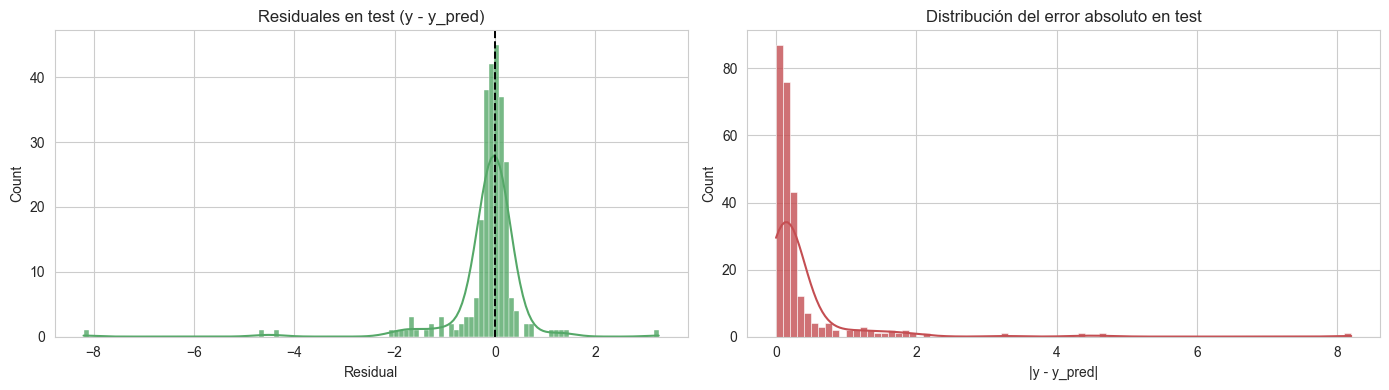

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(residuals_test, bins=30, kde=True, ax=axes[0], color='#55A868', alpha=0.8, binwidth=0.1)
axes[0].axvline(0, color='black', linestyle='--', linewidth=1.4)
axes[0].set_title('Residuales en test (y - y_pred)')
axes[0].set_xlabel('Residual')

sns.histplot(abs_err_test, bins=30, kde=True, ax=axes[1], color='#C44E52', alpha=0.8, binwidth=0.1)
axes[1].set_title('Distribución del error absoluto en test')
axes[1].set_xlabel('|y - y_pred|')

plt.tight_layout()
plt.show()

Por último, las distribuciones de los residuos, muestran un desempeño estable y robusto del modelo asegurando que los errores se concentran fuertemente alrededor de cero y que solo para algunos pocos valores se supera una magnitud de 2 en el error.


<a id="toc-analisis-de-resultados"></a>
## Análisis de resultados


**Análisis cuantitatvo.**

- ¿Cuál modelo obtuvo el mejor desempeño en el conjunto de test?

    En conjuntos de prueba se obtuvo que el mejor modelo es una regresión lineal con regularización L1 (Lasso)

- ¿Coincide el mejor desempeño en test con el mejor promedio en validación cruzada? Si no coincide, ¿cuál puede ser la explicación?

    El desempeño en datos de prueba coincide con el promedio obtenido en la validación cruzada, sin embargo en prueba se comporta ligeramente peor debido a que se evalúa con un mayor conjunto de datos en donde uno de ellos puede afectar estas métricas.

- ¿El modelo con mejor métrica promedio es necesariamente el más adecuado? Justifica considerando también la desviación estándar del desempeño.

    Durante el desarrollo del laboratorio se observó que una regresión polinomial de cuarto grado podría lograr un desempeño similar e incluso mejor al obtenido con la regresión lineal, sin embargo dado la similitud en el desempeño se prefiere el modelo de regresión lineal, dado que es más simple y nos puede indicar una mejor capacidad de generalización.

- Con base en las curvas de validación, ¿cómo cambia el error a medida que aumenta la complejidad? ¿En qué punto se evidencia sobreajuste?

    En las corvas de validación se observa que a medida que se aumenta el grado del polinomio de la regresión, se logra un menor error en datos de entrenamiento pero se aumenta el error en datos de validación, este efecto de sobreajuste se vuelve crítico a partir de un polinomio de tercer grado en donde el modelo empieza a memorizar los datos de entrenamiento y el error de validación crece mucho más.

- ¿Cómo afecta la regularización la magnitud y estabilidad de los coeficientes?

- ¿Los intervalos de confianza obtenidos mediante bootstrapping sugieren estabilidad o alta variabilidad en el desempeño? ¿Qué implicaciones tiene esto?
    Los resultados obtenidos sugieren una alta estabilidad, pues son intervalos cortos con poca dispersión por lo que el modelo se puede considerar robusto frente a datos nuevos cuyas distribuciones no han sido observadas pero el modelo mantiene una capacidad de generalización alta.

**Análisis cualitativo.**

- ¿Qué variables fueron seleccionadas como más relevantes por el modelo Lasso?

- ¿Qué interpretación práctica tienen los coeficientes del modelo final en el contexto del riesgo cardiovascular?

- ¿Existen diferencias relevantes entre el modelo más preciso y el más interpretable?

- ¿Qué decisiones estratégicas podría tomar AlpesHearth a partir de los resultados obtenidos?

- ¿Mayor precisión implica necesariamente mayor valor para la organización? 

- ¿Un modelo más complejo necesariamente genera mayor valor empresarial? Discute considerando interpretabilidad, estabilidad y costo de implementación.

**Reflexión conceptual.**

- ¿Qué relación observas entre complejidad del modelo, capacidad de generalización y estabilidad del desempeño?

- ¿Qué fuentes de sesgo podrían estar presentes en los datos o en el proceso de modelado?

- Si el tamaño de muestra fuera mayor, ¿esperarías cambios en la estabilidad de los modelos? Explique.


<a id="toc-uso-de-ia-generativa"></a>

## Uso de IA Generativa